# Проект Телеком


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.     
**Цель:** обучить модель для прогноза оттока клиентов.
1. Загрузить данные.
2. Предобработка и исследовательский анализ данных.
3. Обучить модель.
4. Протестировать модель и продемонстрировать ее работу.
5. Общий вывод.

# Описание услуг

Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
* Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
* Выделенная линия технической поддержки (Tech Support);
* Облачное хранилище файлов для резервного копирования данных (Online Backup);
* Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года.
* Доступны различные способы расчёта и возможность получить электронный чек.

# Описание данных

Данные хранятся в Sqlite  — СУБД.    
1. `contract` - информация о договорах;
    - customerID — ID абонента;
    - BeginDate — дата начала действия договора;
    - EndDate — дата окончания действия договора;
    - Type — тип оплаты: раз в год-два или ежемесячно;
    - PaperlessBilling — электронный расчётный лист;
    - PaymentMethod — тип платежа;
    - MonthlyCharges — расходы за месяц;
    - TotalCharges — общие расходы абонента.
2. `personal` -  персональные данные клиентов;
    - customerID — ID пользователя;
    - gender — пол;
    - SeniorCitizen — является ли абонент пенсионером;
    - Partner — есть ли у абонента супруг или супруга;
    - Dependents — есть ли у абонента дети.
3. `internet` -  информация об интернет-услугах;
    - customerID — ID пользователя;
    - InternetService — тип подключения;
    - OnlineSecurity — блокировка опасных сайтов;
    - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    - DeviceProtection — антивирус;
    - TechSupport — выделенная линия технической поддержки;
    - StreamingTV — стриминговое телевидение;
    - StreamingMovies — каталог фильмов.
4. `phone` - информация об услугах телефонии.
    - customerID — ID пользователя;
    - MultipleLines — подключение телефона к нескольким линиям одновременно.

# Шаг 1. Загрузка данных

In [ ]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db -q
!pip install phik -q
!pip install shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 37.1 MB/s eta 0:00:00


In [ ]:
import os
import re
import phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import shap
import warnings

from sqlalchemy import create_engine
from sqlalchemy import inspect
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
RANDOM_STATE = 61025
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используем устройство:', device)

Используем устройство: cuda


In [ ]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [ ]:
inspector = inspect(engine)
inspector.get_table_names()

['contract',
 'data_arc',
 'data_bulk',
 'data_bulk_time',
 'data_gas',
 'data_temp',
 'data_wire',
 'data_wire_time',
 'internet',
 'personal',
 'phone']

Обнаружены таблицы не относящиеся к нашему проекту. Выгрузим только необходимые.

In [ ]:
tables = ['contract', 'personal', 'internet', 'phone']
df = {}

for table in tables:
    df[table] = pd.read_sql(f'SELECT * FROM {table}', engine)
    print(f"{table}: {df[table].shape}")

contract = df['contract']
personal = df['personal']
internet = df['internet']
phone = df['phone']

contract: (7043, 8)
personal: (7043, 5)
internet: (5517, 8)
phone: (6361, 2)


## Промежуточный вывод

**Цель:** загрузить данные.
1. Осуществлено подключение к базе данных Sqlite
2. Обнаружны таблицы не имеющие отношения к исселдованию.
3. Выгружены таблицы `contract`, `personal`, `internet`, `phone`, количество столбцов соответсвует заявленному в описании.

# Шаг 2. Предобработка и исследовательский анализ данных.

Приведем названия столбцов к snakecase.

In [ ]:
def camel_to_snake(name):
    """Преобразует CamelCase в snake_case"""
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()


In [ ]:
contract.columns = [camel_to_snake(col) for col in contract.columns]
personal.columns = [camel_to_snake(col) for col in personal.columns]
internet.columns = [camel_to_snake(col) for col in internet.columns]
phone.columns = [camel_to_snake(col) for col in phone.columns]

In [ ]:
def eda_df(df):
    """Выводит базовую информацию о таблице:
    - первые 5 строк
    - информация
    - describe()
    - количество пропусков
    - количество дубликатов
    """
    display(df.head())

    print('\n Статистическое описание:')
    display(df.describe(include='all'))
    display(df.info())

    print('\n Количество пропусков:')
    print(df.isna().sum()[df.isna().sum() > 0])

    dups = df.duplicated().sum()
    print(f'\n Явных дубликатов: {dups}')


In [ ]:
eda_df(contract)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5



 Статистическое описание:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,1585,6658
top,3186-AJIEK,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,
freq,1,366,5942,3875,4171,2365,61,11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        7043 non-null   object
 1   begin_date         7043 non-null   object
 2   end_date           7043 non-null   object
 3   type               7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   monthly_charges    7043 non-null   object
 7   total_charges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


None


 Количество пропусков:
Series([], dtype: int64)

 Явных дубликатов: 0


Пропуски не обнаружены, явные дублкаты тоже, ID абонентов уникальны. Нужно исправить типы данных. Проверим на наличие неявных дубликатов.

In [ ]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d', errors='coerce')
contract['monthly_charges'] = contract['monthly_charges'].astype(float)
contract['total_charges'] = contract['total_charges'].replace(' ', np.nan).astype(float)

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Заполним пропуски в end_date на 2020-02-01.

In [ ]:
contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [ ]:
eda_df(personal)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



 Статистическое описание:


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,3186-AJIEK,Male,0,No,No
freq,1,3555,5901,3641,4933


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None


 Количество пропусков:
Series([], dtype: int64)

 Явных дубликатов: 0


Явные и неявные дубликаты, пропуски не обнаружены. В столбце senior_citizen содержатся бинарные значения 0/1 хотя в остальных столбцах Yes/No. Оставим пока как есть.

In [ ]:
eda_df(internet)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



 Статистическое описание:


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3186-AJIEK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


 Количество пропусков:
Series([], dtype: int64)

 Явных дубликатов: 0


In [ ]:
eda_df(phone)

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



 Статистическое описание:


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,3186-AJIEK,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


 Количество пропусков:
Series([], dtype: int64)

 Явных дубликатов: 0


Создадим целевой признак `target` в котором в бинарном виде 0/1 укажем прекратил(1), не прекратил(0) клиент пользоваться услугами компании.

In [ ]:
off_date = pd.to_datetime('2020-02-01')

contract['target'] = 1

mask_active = contract['end_date'].isna() | (contract['end_date'] >= off_date)
contract.loc[mask_active, 'target'] = 0

contract['end_date'] = contract['end_date'].fillna(pd.Timestamp('2020-02-01'))

Создадим столбец `duration` с количеством дней пользования услугами компании.

In [ ]:
contract['duration'] = (contract['end_date'] - contract['begin_date']).dt.days

Создадим единый датафрейм `df`.

In [ ]:
df = contract.merge(internet, on='customer_id', how='left')
df = df.merge(personal, on='customer_id', how='left')
df = df.merge(phone, on='customer_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   target             7043 non-null   int64         
 9   duration           7043 non-null   int64         
 10  internet_service   5517 non-null   object        
 11  online_security    5517 non-null   object        
 12  online_backup      5517 non-null   object        
 13  device_protection  5517 non-null   object        
 14  tech_sup

Обнаружились вполне логичные пропуски в бинарных категориальных признаках(Yes/No), заполним эти пропуски значениями No. Ведь если нет инфорации, то пользователь вероятнее всего не пользуется этими услугами.

Так же обработаем 11 пропусков в столбце `total_charges`.

In [ ]:
df[df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,...,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0,...,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0,...,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0,...,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Итак, информация total_charges отсутсвует у тех клиентов, что зарегистрировались 2020-02-01. Заполним пропуски суммой monthly_charges.

In [ ]:
df['total_charges'] = df['total_charges'].fillna(df['monthly_charges'])
df['multiple_lines'] = df['multiple_lines'].fillna('No phone')
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   int64         
 9   duration           7043 non-null   int64         
 10  internet_service   7043 non-null   object        
 11  online_security    7043 non-null   object        
 12  online_backup      7043 non-null   object        
 13  device_protection  7043 non-null   object        
 14  tech_sup

Удалим ненужные столбцы и customer_id переведем в индекс.

In [ ]:
df = df.drop(['begin_date', 'end_date'], axis=1)
df = df.set_index('customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   target             7043 non-null   int64  
 6   duration           7043 non-null   int64  
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  gender             7043 non-null   object 
 15  senior_citizen     7043 non-null   object 
 16  partner       

Построим графики.

### EDA

In [ ]:
def quantitative_features(attribute, title='', bins=20):
    """
    Визуализация количественного признака:
    - гистограмма по классам таргета
    - boxplot по классам таргета
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(data=df, x=attribute, hue='target', bins=bins, kde=True, ax=ax[0], palette='Set2', alpha=0.6)
    ax[0].set_title(f'{title} — распределение по классам target', fontsize=13)
    ax[0].set_xlabel(attribute)
    ax[0].set_ylabel('Количество')

    sns.boxplot(data=df, x='target', y=attribute, palette='Set2', ax=ax[1])
    ax[1].set_title(f'{title} — boxplot по классам target', fontsize=13)
    ax[1].set_xlabel('target')
    ax[1].set_ylabel(attribute)

    plt.tight_layout()
    plt.show()

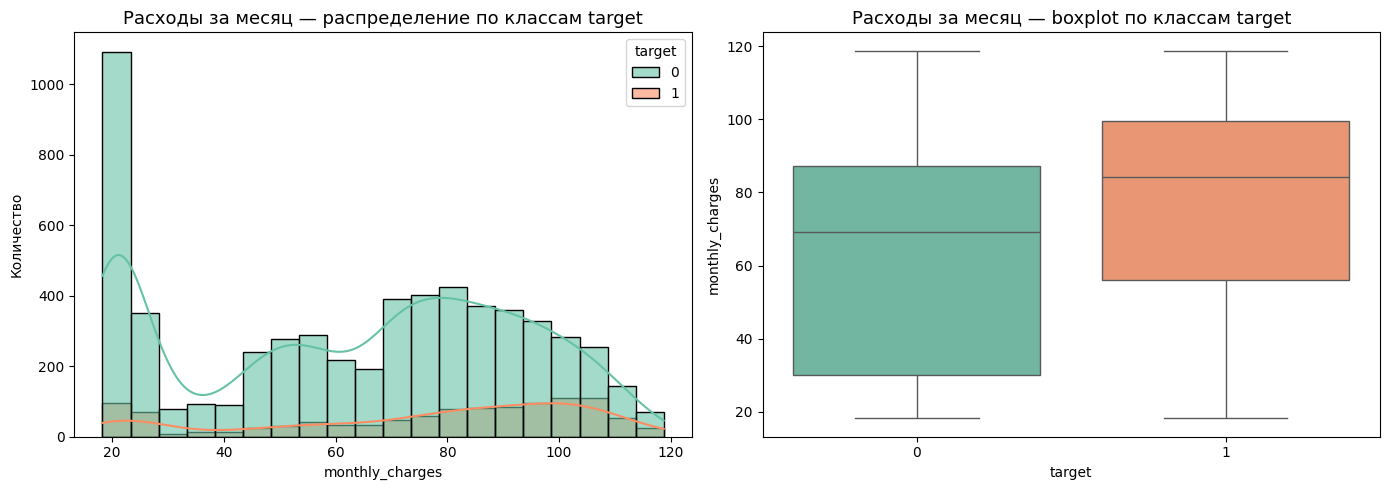

In [ ]:
quantitative_features('monthly_charges', 'Расходы за месяц')

Много клиентов имеет оплату около 20, скорее всего это клиенты которые платят ежемесячно.

In [ ]:
subset = contract.query('monthly_charges <= 20')
subset['type'].value_counts()


,count
type,
Month-to-month,253
Two year,238
One year,165


Ага, в месяц у 1/5 клиентов выходят расходы на примерно 20. Плата остальных киентов выше и может достигать 120.

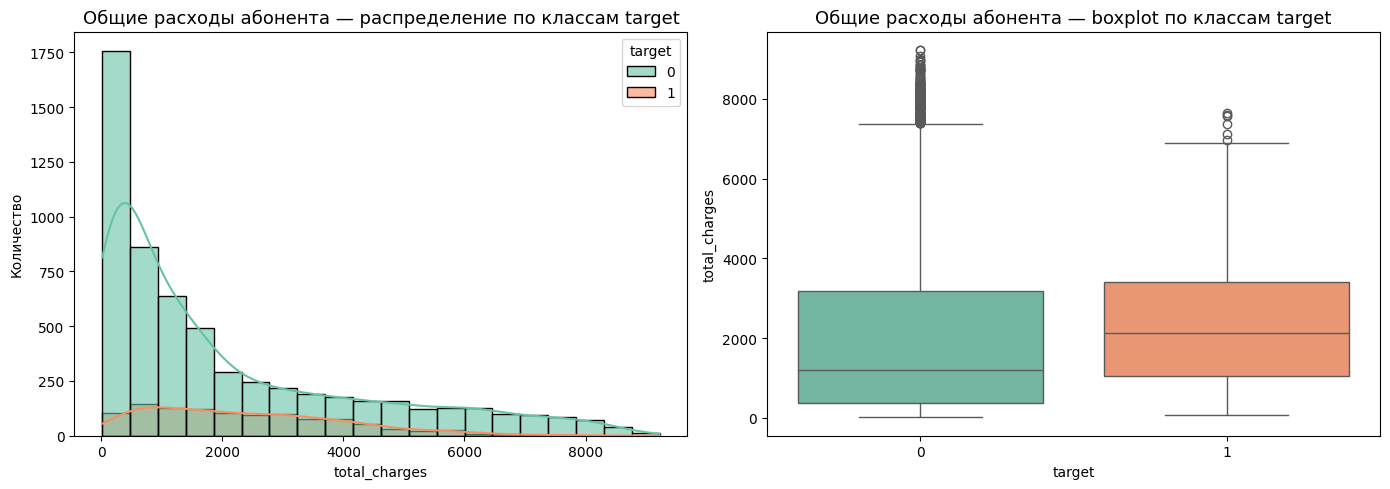

In [ ]:
quantitative_features('total_charges', 'Общие расходы абонента')

In [ ]:
contract[contract['total_charges']<20]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration
101,3679-XASPY,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.45,19.45,0,31
128,3930-ZGWVE,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.75,19.75,0,31
310,1098-TDVUQ,2020-01-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),19.25,19.83,0,31
542,2866-IKBTM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0,31
583,1423-BMPBQ,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,19.00,19.19,0,31
1168,5562-BETPV,2020-01-01,2020-02-01,One year,No,Mailed check,19.65,19.65,0,31
1252,7617-EYGLW,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.45,19.45,0,31
1373,4291-HPAXL,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.85,19.85,0,31
1491,8605-ITULD,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0,31
1654,2967-MXRAV,2020-01-01,2020-02-01,One year,No,Mailed check,18.80,19.74,0,31


Присутсвует 31 клиент у которых общий счет за все время использования, все эти клиенты заключили договор с компанией 01-01-2020, то есть они оплатили лишь месяц использвования связью.
Больше смущают суммы более 6500.

In [ ]:
high_charges = contract[contract['total_charges'] > 6500]
high_charges_2014 = high_charges[high_charges['begin_date'].dt.year == 2014]
len(high_charges_2014) / len(high_charges)

0.9331619537275064

93% клиентов с суммой счета за весь период пользования более 6500 - клиенты заключившие договор в 2014 году. У них могла накопиться такая сумма.

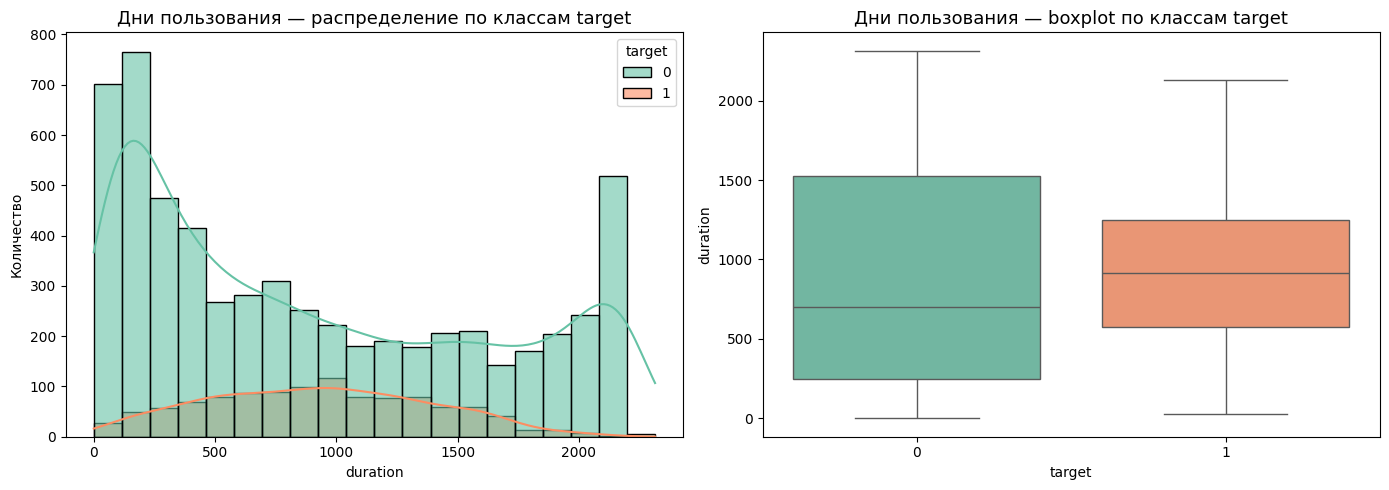

In [ ]:
quantitative_features('duration', 'Дни пользования')

В основном, прекращают пользоваться услугами компании те клиенты, которые пользуются услугами от 600 до 1250 дней. Много клиентов которые пользуются услугами компании менее года.

In [ ]:
def categorical_features(attribute, title='', top_n=10):
    """
    Визуализация категориального признака:
    - Круговая диаграмма
    - Гистограмма распределения по классам target
    """
    counts = df[attribute].value_counts().head(top_n)
    filtered_df = df[df[attribute].isin(counts.index)]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    counts.plot.pie(autopct='%1.1f%%', ax=axes[0], cmap='Pastel1')
    axes[0].set_ylabel('')
    axes[0].set_title(f"{title} — Доли")

    sns.countplot(x=attribute, hue='target', data=filtered_df,
                  order=counts.index, ax=axes[1], palette='Set2')
    axes[1].set_title(f"{title} — распределение по классам target")
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    print(counts)

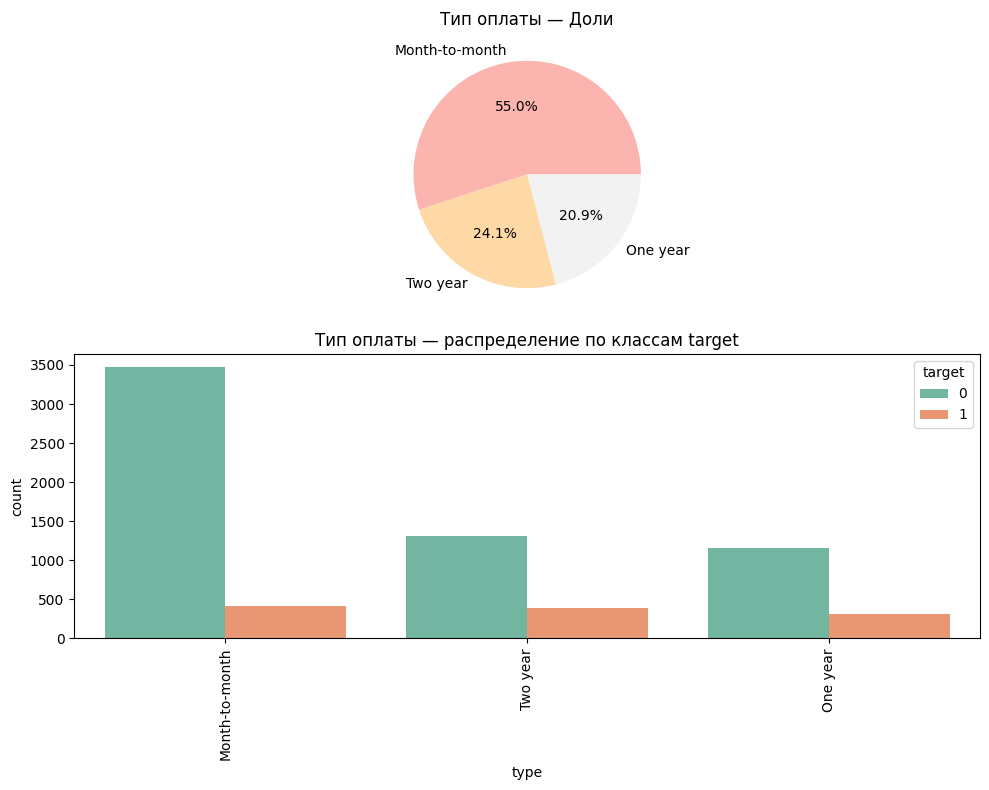

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


In [ ]:
categorical_features('type', 'Тип оплаты')

Большинство клиентов предпочитают оплачивать услуги ежемесячно. Доля ушедших клиентов выше всего у клиентов с 1-2летними контрактами.

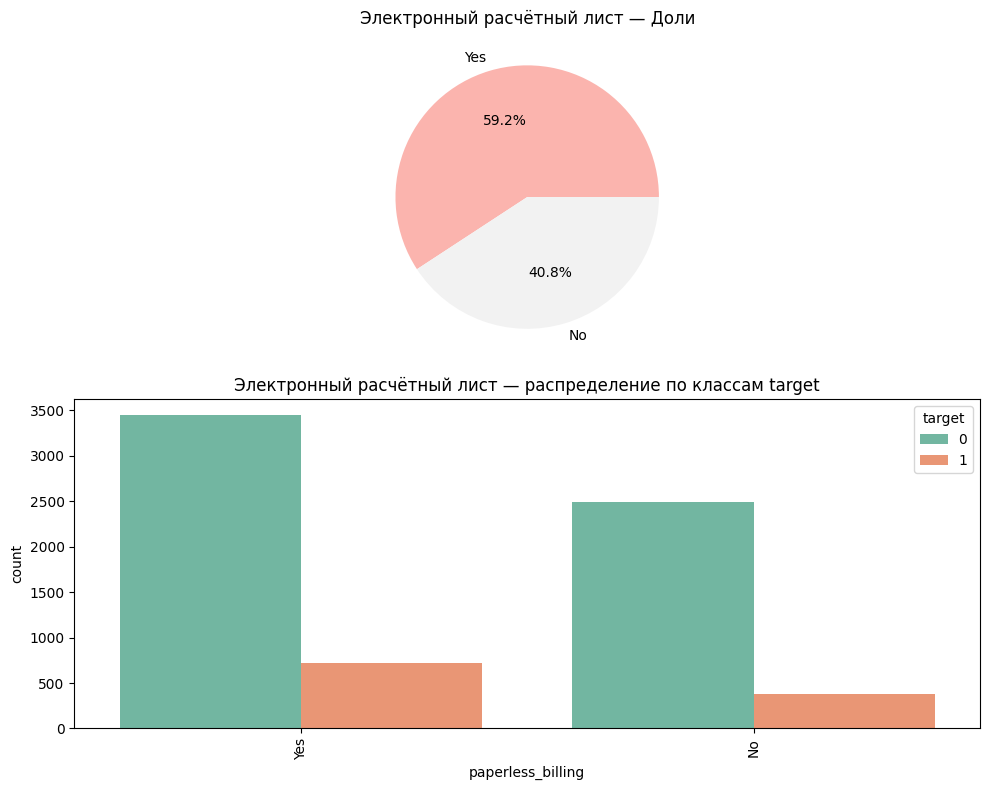

paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64


In [ ]:
categorical_features('paperless_billing', 'Электронный расчётный лист')

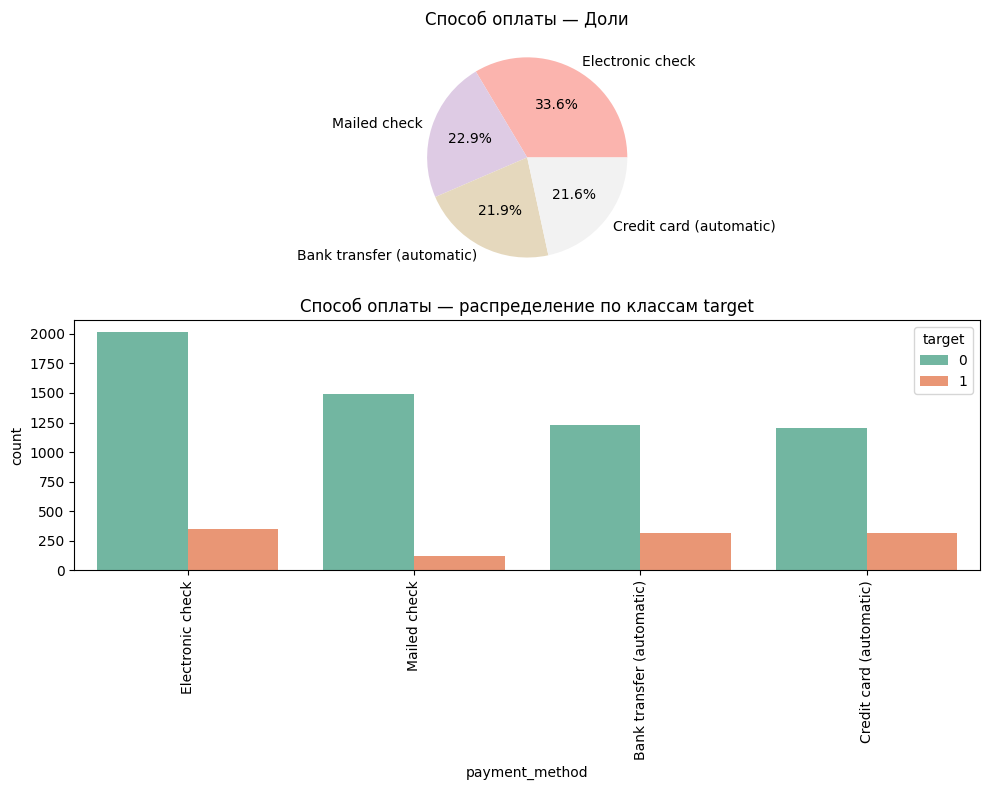

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


In [ ]:
categorical_features('payment_method', 'Способ оплаты')

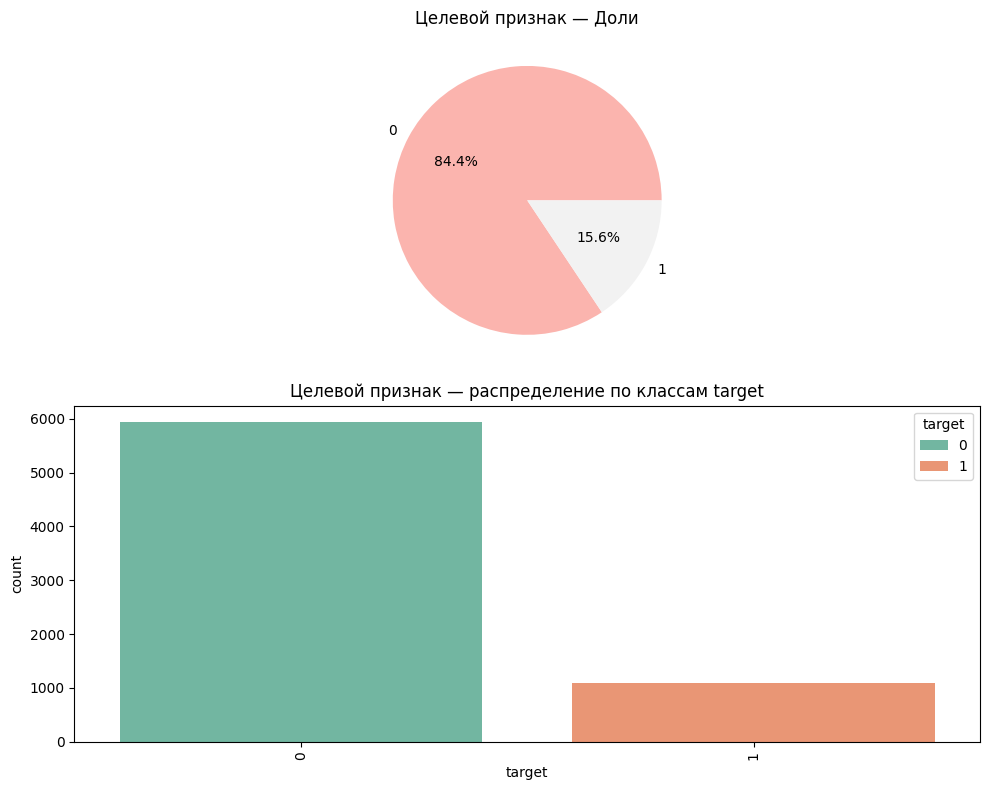

target
0    5942
1    1101
Name: count, dtype: int64


In [ ]:
categorical_features('target', 'Целевой признак')

Как мы знали заранее, у нас дисбаланс классов, который нужно будет учесть при обучении модели.

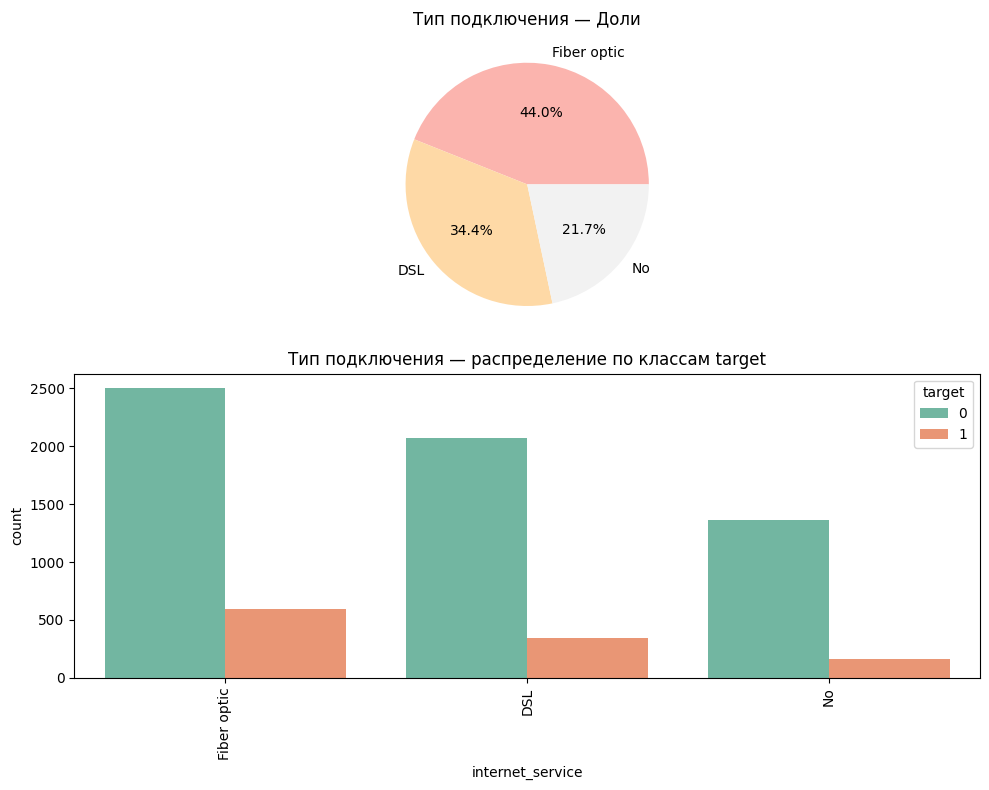

internet_service
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


In [ ]:
categorical_features('internet_service', 'Тип подключения')

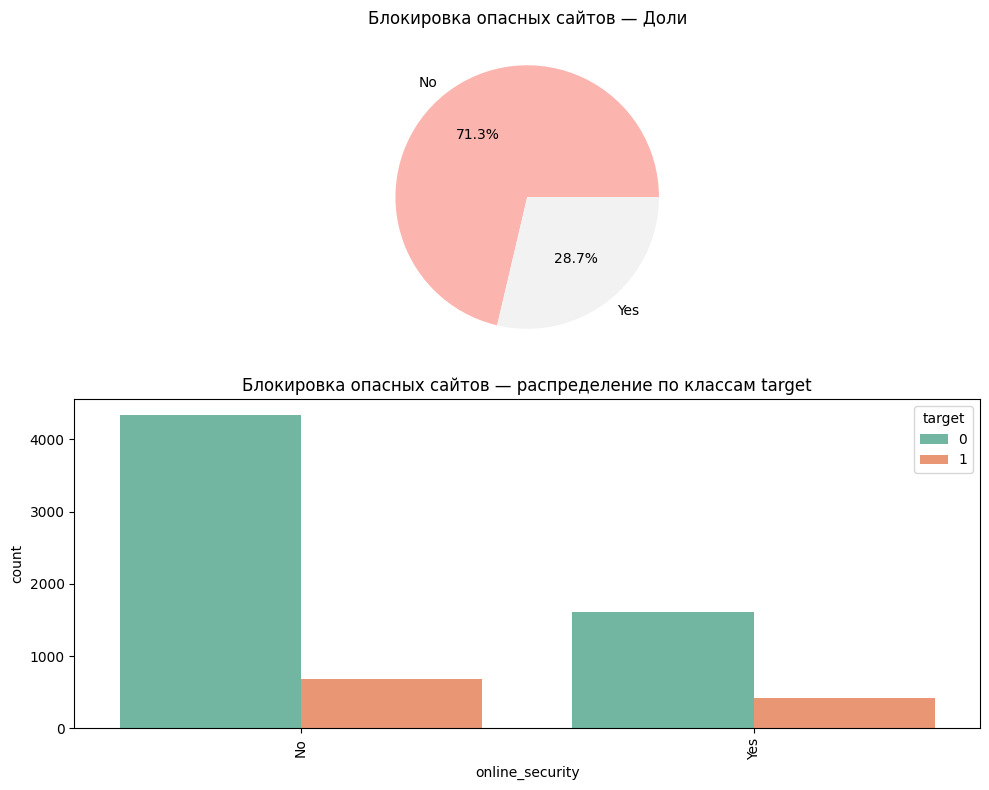

online_security
No     5024
Yes    2019
Name: count, dtype: int64


In [ ]:
categorical_features('online_security', 'Блокировка опасных сайтов')

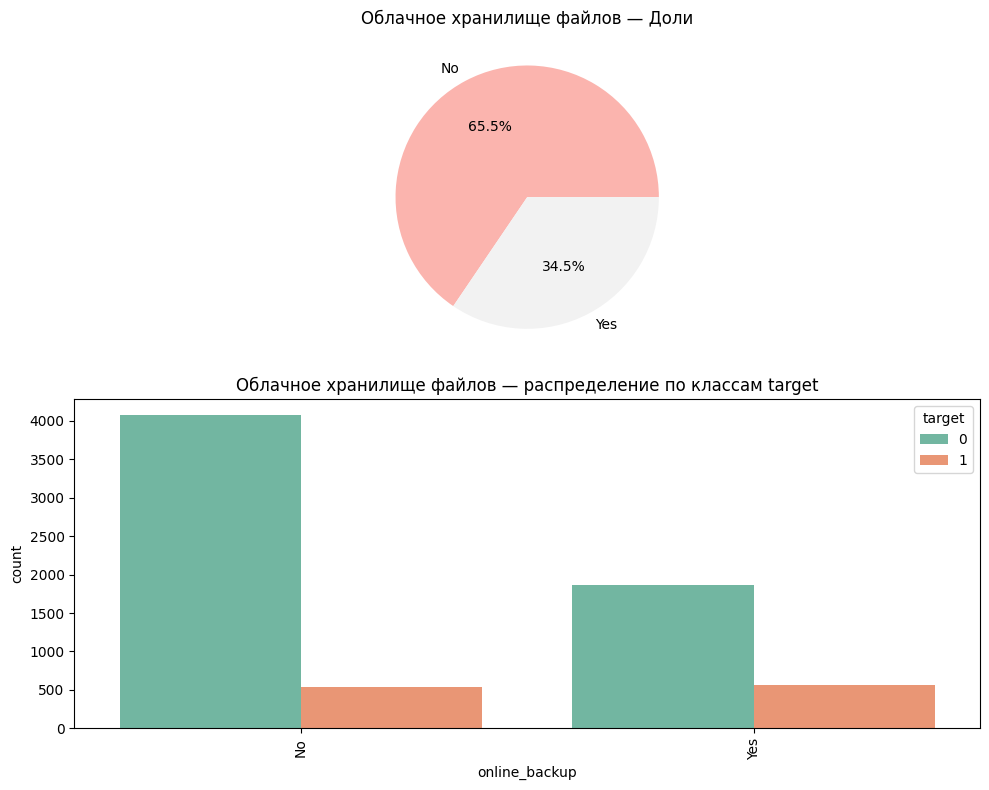

online_backup
No     4614
Yes    2429
Name: count, dtype: int64


In [ ]:
categorical_features('online_backup', 'Облачное хранилище файлов')

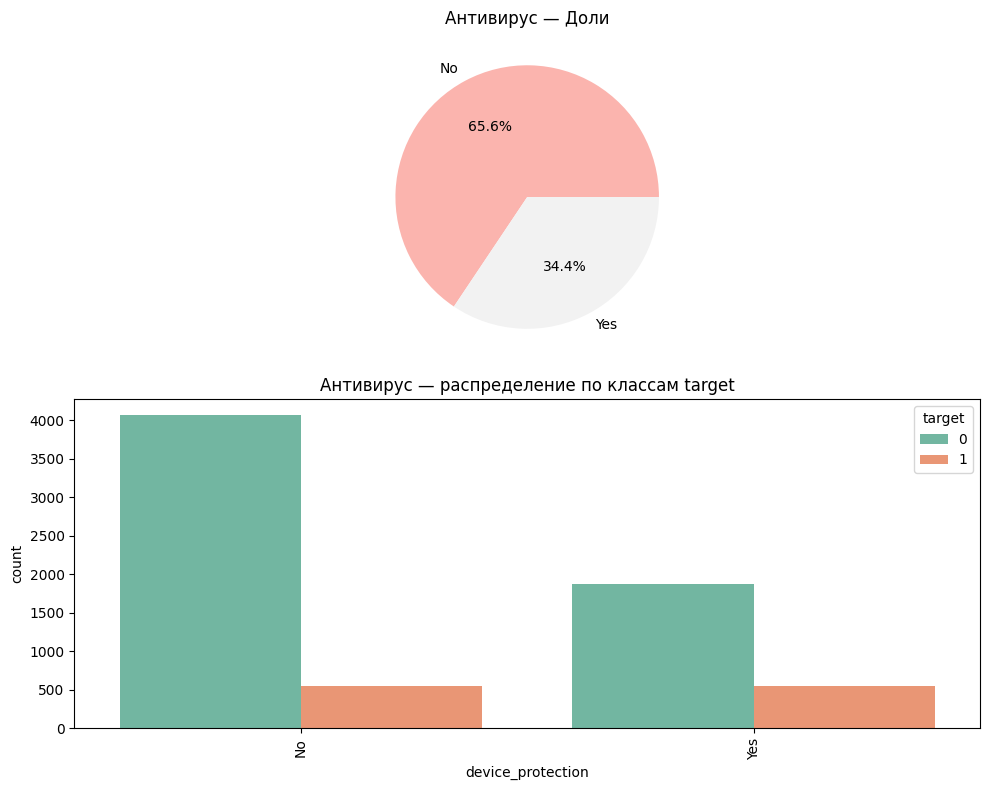

device_protection
No     4621
Yes    2422
Name: count, dtype: int64


In [ ]:
categorical_features('device_protection', 'Антивирус')

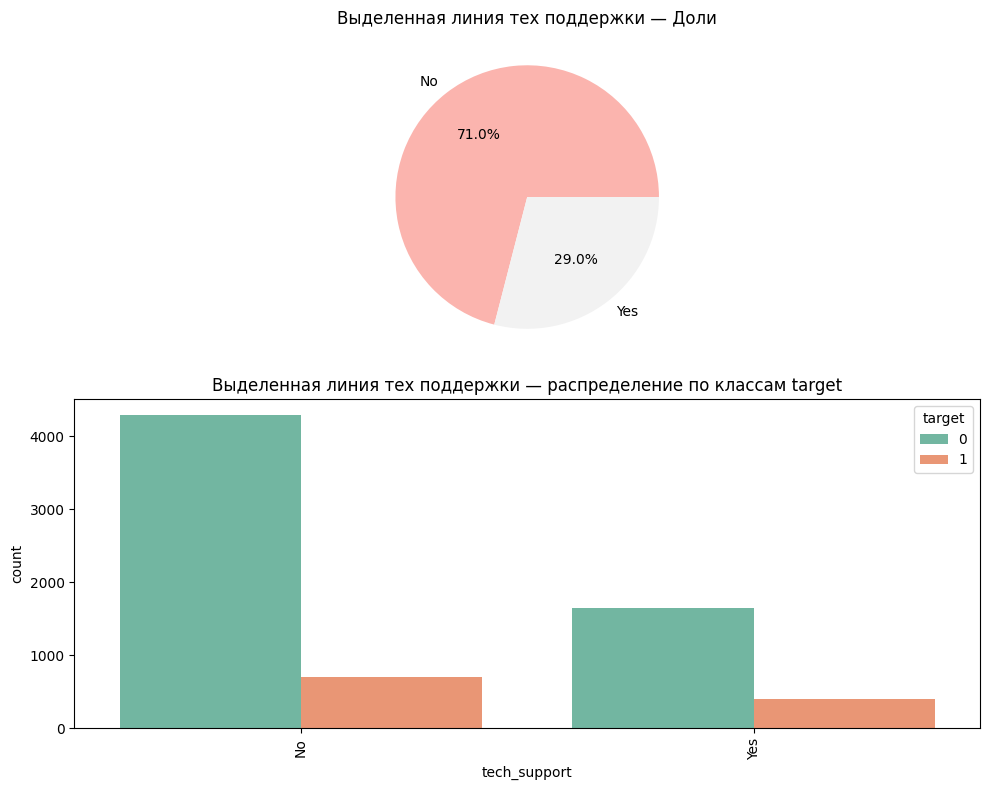

tech_support
No     4999
Yes    2044
Name: count, dtype: int64


In [ ]:
categorical_features('tech_support', 'Выделенная линия тех поддержки')

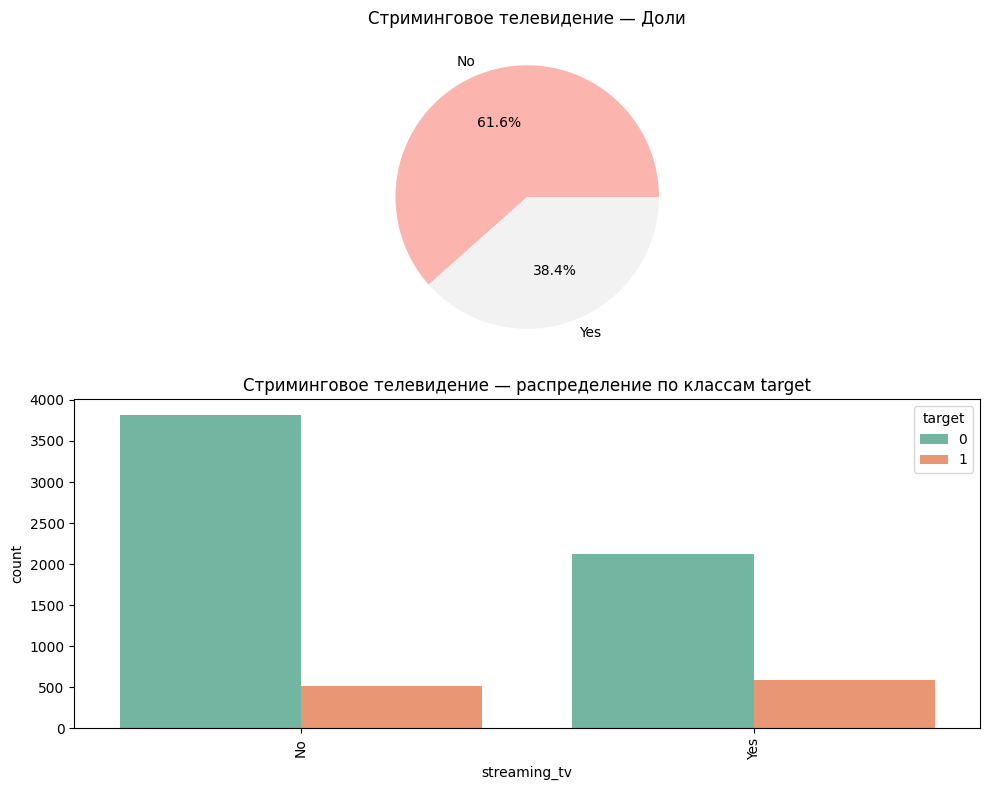

streaming_tv
No     4336
Yes    2707
Name: count, dtype: int64


In [ ]:
categorical_features('streaming_tv', 'Стриминговое телевидение')

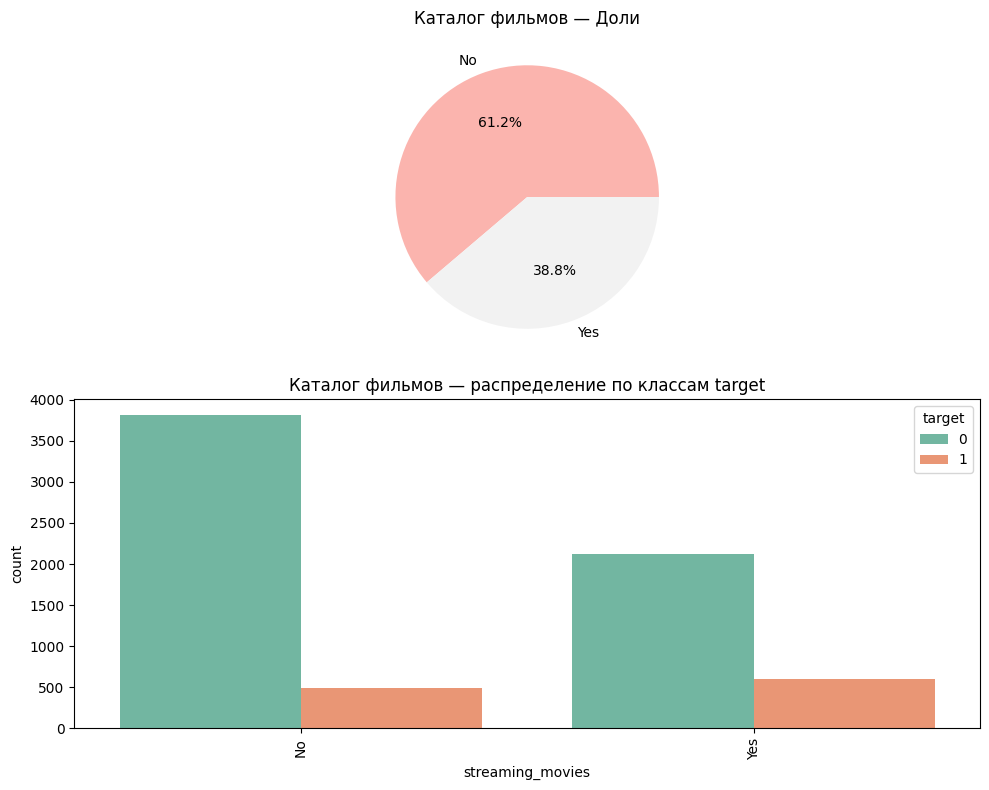

streaming_movies
No     4311
Yes    2732
Name: count, dtype: int64


In [ ]:
categorical_features('streaming_movies', 'Каталог фильмов')

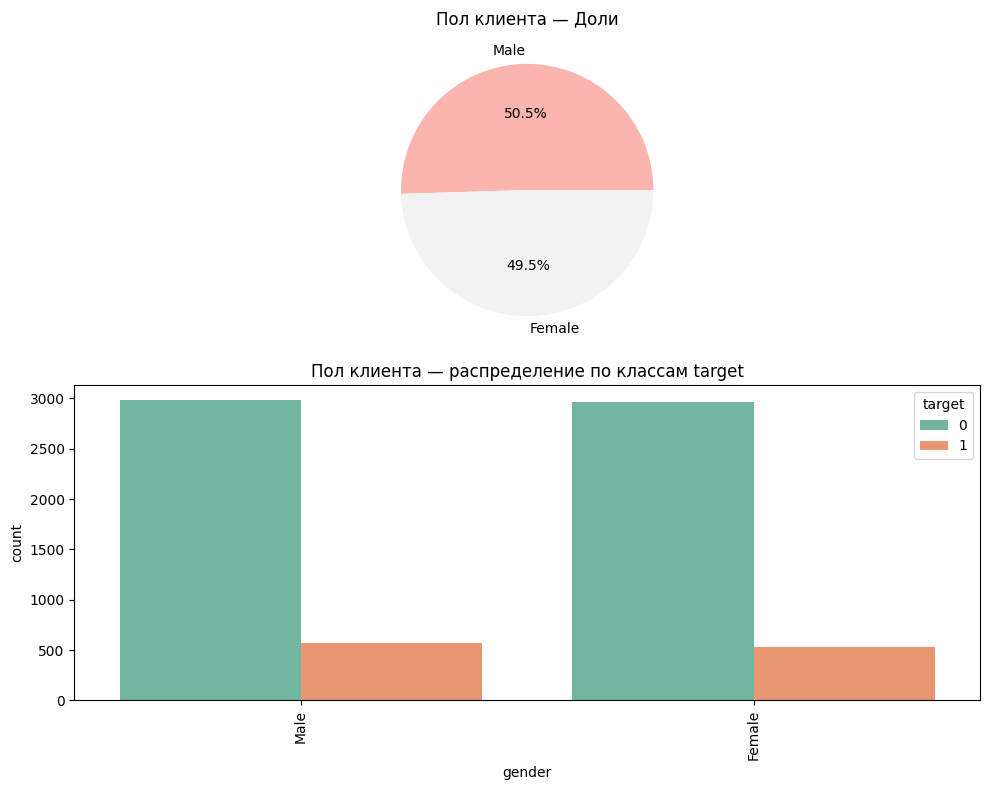

gender
Male      3555
Female    3488
Name: count, dtype: int64


In [ ]:
categorical_features('gender', 'Пол клиента')

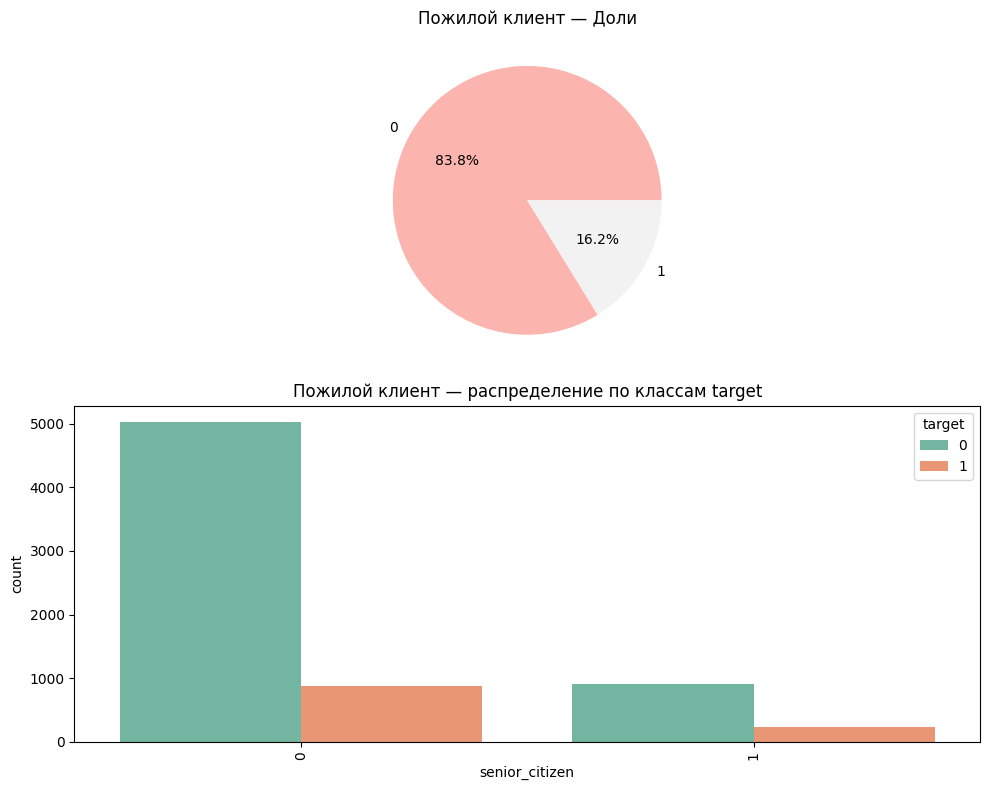

senior_citizen
0    5901
1    1142
Name: count, dtype: int64


In [ ]:
categorical_features('senior_citizen', 'Пожилой клиент')

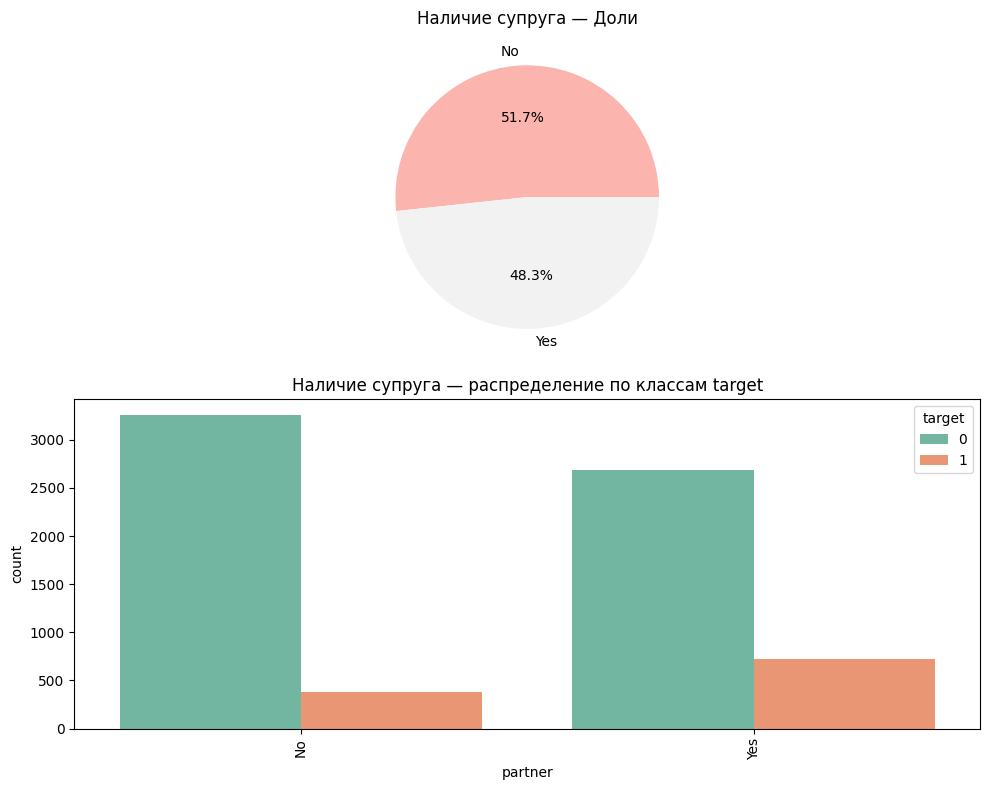

partner
No     3641
Yes    3402
Name: count, dtype: int64


In [ ]:
categorical_features('partner', 'Наличие супруга')

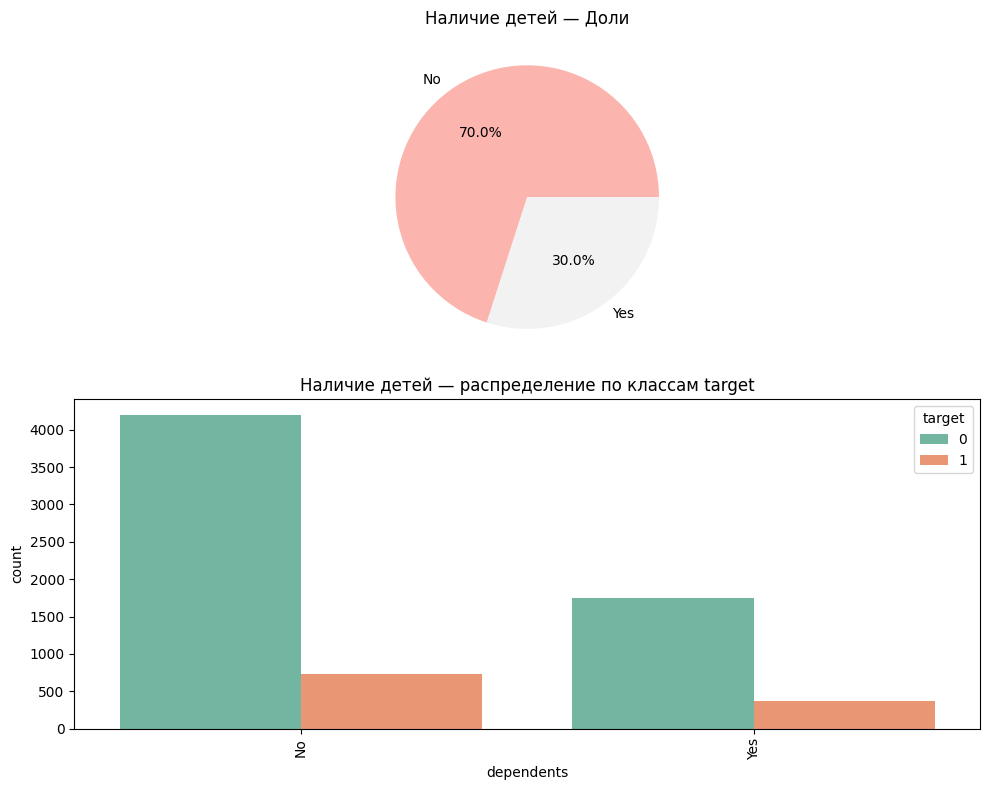

dependents
No     4933
Yes    2110
Name: count, dtype: int64


In [ ]:
categorical_features('dependents', 'Наличие детей')

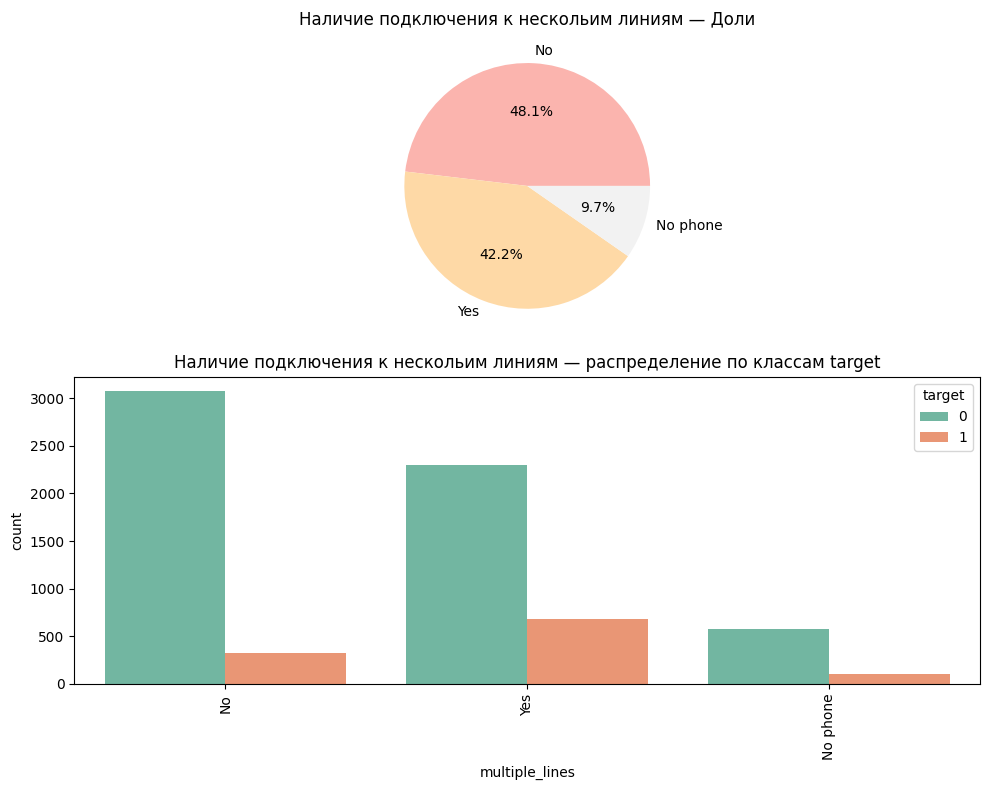

multiple_lines
No          3390
Yes         2971
No phone     682
Name: count, dtype: int64


In [ ]:
categorical_features('multiple_lines', 'Наличие подключения к нескольим линиям')

Составим портрет типичного клиента компании "ТелеДом"

**Типичный клиент (не ушедший):**  
- Пол: мужчина или женщина с равной вероятностью  
- Возраст: не пожилой  
- Семейное положение: не в браке, без детей  
- Оплата услуг: ежемесячная  
  - Предпочтение: электронная рассылка счёта (Paperless Billing)  
  - Метод оплаты: через сайт провайдера или онлайн-банк (Electronic Check)  
- Интернет: оптоволоконный кабель (Fiber optic)  
- Дополнительные услуги: **не подключены**  
- Стационарный телефон: **одна линия**  

---

**Портрет клиента, который отказался от услуг (ушёл):**  
- Пол: мужчина, не пожилой  
- Семейное положение: в браке, без детей  
- Стационарный телефон: подключение к **нескольким линиям**  
- Оплата услуг: раз в год или два, счёт электронный, автоматические списания с кредитной карты
- Интернет: оптоволоконный кабель  
- Дополнительные услуги: **подключены**   

**Статистические показатели:**  
- Средняя длительность пользования услугами:  
  - Ушедшие: ~1000 дней  
  - Не ушедшие: ~750 дней  
- Общие расходы: примерно одинаковы  
- Средний ежемесячный платёж:  
  - Ушедшие: на 20$ выше  
  - Межквартильный размах:  
    - Ушедшие: 58–100  
    - Не ушедшие: 30–88


  **Складывается мнение, что клиенты уходят из-за отсутсвия возможности управлять расходами. У ушедших клиентов оплата ваыше, контракты с компанией дольше и больше подписок, которые увеличивают стоимость услуг.**


Построим матрицу корреляции.

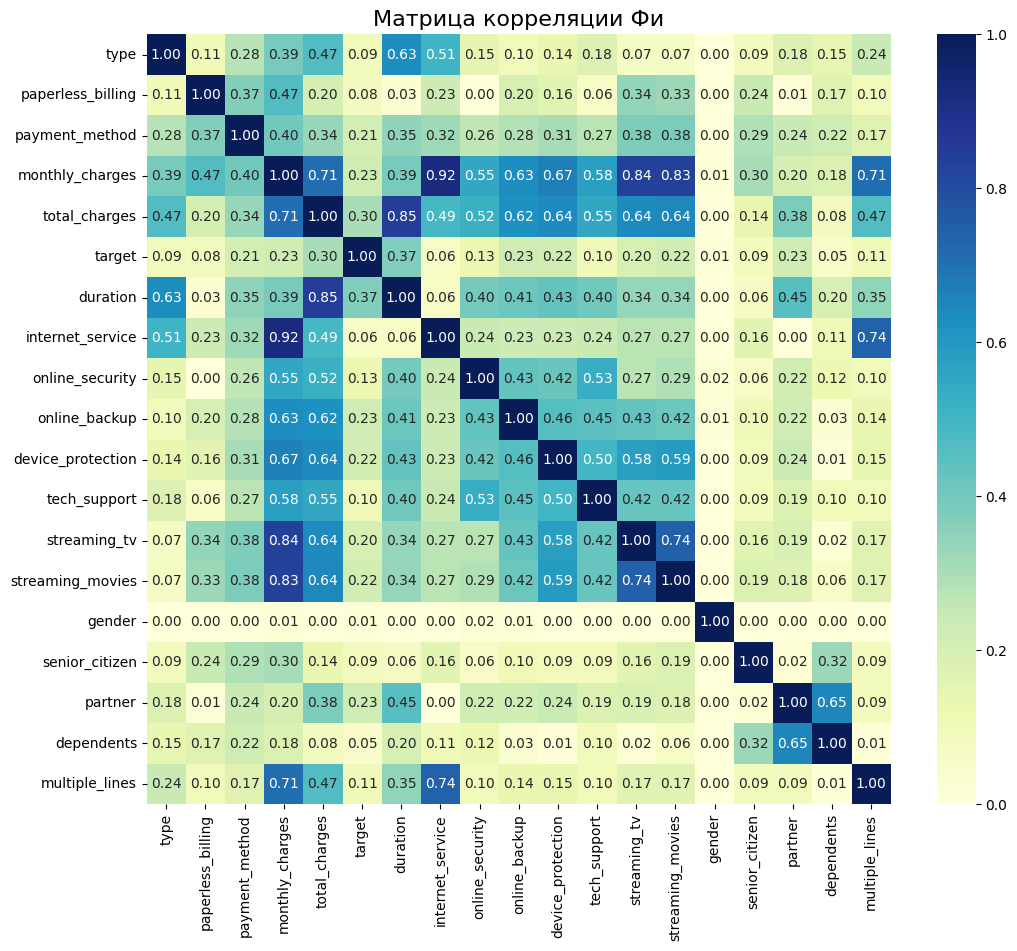

In [ ]:
df_phik = df.copy()

interval_cols = df_phik.select_dtypes(include=['number']).columns.tolist()
phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Итак, ЦП имеет умеренно-слабую линейную зависимость с `duratrion`, `totaL_charges`.   
Наблюдлается мультиколлинеарность `monthly_charges` <-> `internet_service`, `streming_tv`, `streming_movies`. Чем больше сервисов подключено, тем выше ежемесячная стоимость, логично.    
Так же смущает сильная зависимость между `monthly_charges` и `totaL_charges`, оставим только `monthly_charges`, так как `totaL_charges` дублирует информацию `duration`.
Предлагаю сделать так: удаляем столбцы `gender`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `partner`, `dependents`, `internet_service`.    
Создать новый столбец с количеством подключенных сервисов `serveces`. Столбец `family` с бинарным признаком 1/0, имеется и партнер и ребенок.

In [ ]:
service_cols = [
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]

family_cols = ['partner','dependents']

df[service_cols] = df[service_cols].apply(lambda col: col.map({'Yes': 1, 'No': 0}))

df['services'] = df[service_cols].sum(axis=1)

df[family_cols] = df[family_cols].apply(lambda col: col.map({'Yes': 1, 'No': 0}))

df['family'] = df['partner'] | df['dependents']
df.drop(columns=service_cols + ['gender','partner','dependents', 'internet_service', 'total_charges'], inplace=True)

df['paperless_billing'] = df['paperless_billing'].map({'Yes': 1, 'No': 0})

In [ ]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,target,duration,senior_citizen,multiple_lines,services,family
customer_id,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,0,31,0,No phone,1,1
5575-GNVDE,One year,0,Mailed check,56.95,0,1036,0,No,2,0
3668-QPYBK,Month-to-month,1,Mailed check,53.85,0,123,0,No,2,0
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,0,1371,0,No phone,3,0
9237-HQITU,Month-to-month,1,Electronic check,70.70,0,153,0,No,0,0


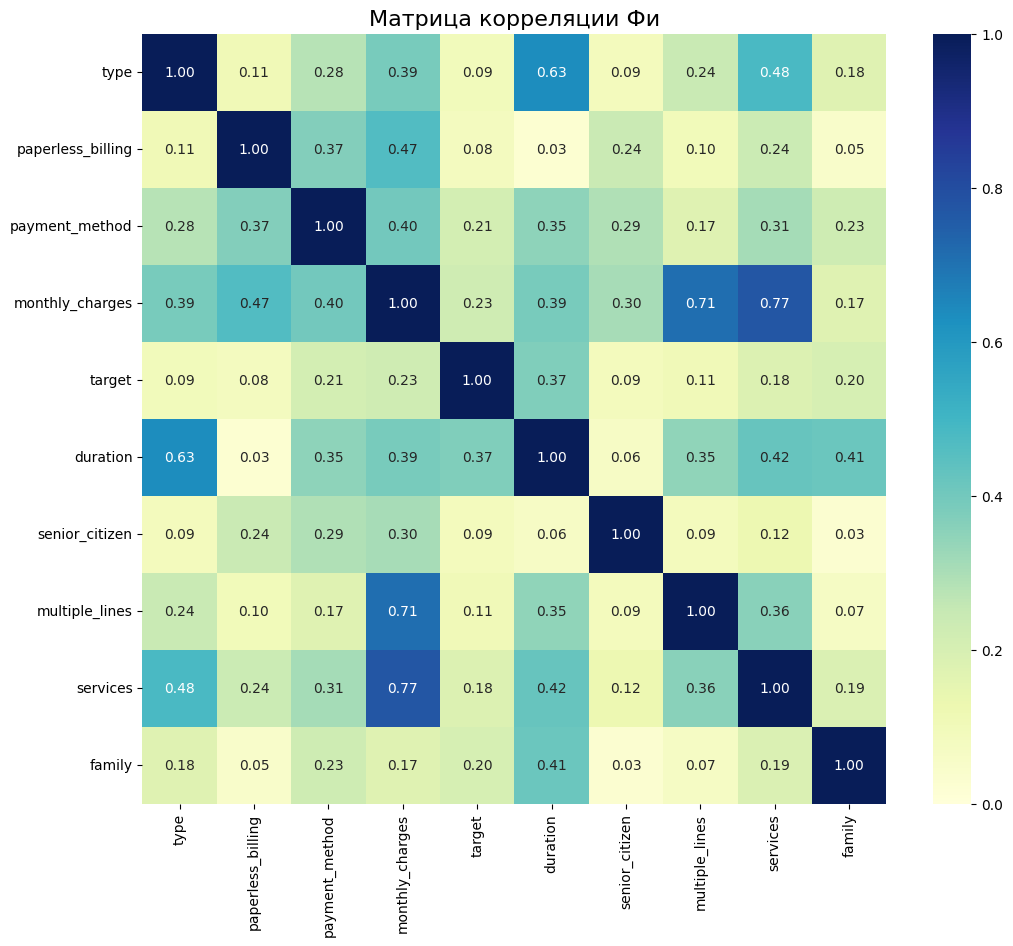

In [ ]:
df_final = df.copy()

interval_cols = df_final.select_dtypes(include=['number']).columns.tolist()
phik_overview_final = df_final.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_overview_final, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Оставим такой набор входных признаков.   
Проверим на дубликаты, так как ранее мы перевели `customer_id` в индекс.

In [ ]:
print(f'Количество выявленных явных дубликатов: {df_final.duplicated().sum()}')

Количество выявленных явных дубликатов: 53


Удалим дубликаты.

In [ ]:
df_final = df_final.drop_duplicates()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6990 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               6990 non-null   object 
 1   paperless_billing  6990 non-null   int64  
 2   payment_method     6990 non-null   object 
 3   monthly_charges    6990 non-null   float64
 4   target             6990 non-null   int64  
 5   duration           6990 non-null   int64  
 6   senior_citizen     6990 non-null   object 
 7   multiple_lines     6990 non-null   object 
 8   services           6990 non-null   int64  
 9   family             6990 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 600.7+ KB


Разделим на тренировочную и обучающую выборки в соотношении 1:4.

In [ ]:
X = df_final.drop('target', axis=1)
y = df_final['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE,  stratify=y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5242, 9)
(1748, 9)
(5242,)
(1748,)


## Промежуточный вывод

**Цель:** предобработка и исследовательский анализ данных.
1. Названия столбцов приведены к snakecase, в датафрейме `contract` датированные признаки приведены к типу данных datetime, числовые к типу float, заполонены пропуски в столбце end_date на значение '2020-01-01'.
2. Датафреймы объединены в `df`, созданы признаки `duration` с количеством дней пользования услугами компании и `target` на основе значений столбца `end_date`.
3. В `df` обработаны пропуски, в категориальных столбцах все пропуски приняли значение No, в `total_charges` заполенны значениями из `monthly_charges`.
4. Созданы функции quantitive_features и categorical_features для визуализации признаков.
5. Установлено, что чаще всего уходят клиенты, у которых стационарный телефон подключен к нескольким линиям, оплата услуг 1-2 раза в год, оплата автоматически списывается с кредитной карты и у которых подключены дополнительные услуги.
6. Целевой признак умерено коррелирует с `duration`, удалены столбцы `online_security`, `online_backup`, `device_protection`, `tech_support` `streaming_tv`, `streaming_movies`, `partner`, `dependents`, `gender`.
7. Созданы столбцы `family`, `services` с информацией о наличии семьи (и партнера и ребенка), информацией о количестве подписок на дополнителные услуги.
8. В df_final удалено 53 дубликата, данные разбиты на тренировочную и тестовую выборки.

# Шаг 3. Обучение модели.

Перед нами стоит задача классификации. Для обучения модели выберем такие модели как RandomForestClassifier, XGBoost, LightGBM и нейросеть. Подбор гиперпараметров произведем с помощью GridSearchCV.  
Категориальные признаки закодируем OrdinalEncoder так как в наших столбцах не так много значений. Количественные и бинарные признаки оставим в нативном виде.

In [ ]:
num_cols = ['monthly_charges', 'duration', 'services']
cat_cols = ['type', 'payment_method', 'multiple_lines']
bin_cols = ['paperless_billing', 'family', 'senior_citizen']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OrdinalEncoder(), cat_cols),
        ('bin', 'passthrough', bin_cols)
    ]
)

Отдельно подготовим дланные для LGBM.

In [ ]:
preprocessor_lgb = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('bin', 'passthrough', bin_cols)
])

X_lgb_train = X_train.copy()
for col in num_cols:
    if col in X_lgb_train.columns:
        X_lgb_train[col] = pd.to_numeric(X_lgb_train[col], errors='coerce')
for col in bin_cols:
    if col in X_lgb_train.columns:
        X_lgb_train[col] = X_lgb_train[col].astype('bool')
for col in cat_cols:
    if col in X_lgb_train.columns:
        X_lgb_train[col] = X_lgb_train[col].astype('category')

In [ ]:
def tune_classification_model(model, param_grid, X, y, preprocessor=None, X_preproc=None):
    """
    Универсальная функция для всех моделей.
    Если X_preproc передан, используем его напрямую (для LightGBM),
    иначе применяем preprocessor (для RandomForest/XGBoost)
    """
    if X_preproc is not None:
        pipe = Pipeline([('model', model)])
        X_fit = X_preproc
    else:
        pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
        X_fit = X

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_fit, y)

    return {
        'model': type(model).__name__,
        'params': grid.best_params_,
        'roc_auc': round(grid.best_score_, 4),
        'model_obj': grid.best_estimator_
    }

In [ ]:
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
        'preprocessor': preprocessor,
        'params': {
            'model__n_estimators': [100, 300],
            'model__max_depth': [5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=RANDOM_STATE,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        ),
        'preprocessor': preprocessor,
        'params': {
            'model__n_estimators': [100, 300],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.01, 0.1]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            categorical_feature=cat_cols
        ),
        'X_preproc': X_lgb_train,
        'params': {
            'model__n_estimators': [100, 300],
            'model__num_leaves': [3, 5, 7],
            'model__max_depth': [5, 10],
            'model__learning_rate': [0.01, 0.1]
        }
    }
}

In [ ]:
best_models = {}

for name, mp in models_params.items():
    print(f'=== {name} ===')

    if name == 'LightGBM':
        X_fit = mp['X_preproc']
        preprocessor_to_use = None
    else:
        X_fit = X_train
        preprocessor_to_use = preprocessor

    res = tune_classification_model(
        model=mp['model'],
        param_grid=mp['params'],
        X=X_train,
        y=y_train,
        preprocessor=preprocessor_to_use,
        X_preproc=X_fit if name == 'LightGBM' else None
    )

    best_models[name] = res['model_obj']
    print('Лучшие параметры:', res['params'])
    print('ROC-AUC:', res['roc_auc'])

=== RandomForest ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры: {'model__max_depth': 5, 'model__n_estimators': 300}
ROC-AUC: 0.8234
=== XGBoost ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}
ROC-AUC: 0.9027
=== LightGBM ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] categorical_feature is set=type,payment_method,multiple_lines, categorical_column=0,2,6 will be ignored. Current value: categorical_feature=type,payment_method,multiple_lines
[LightGBM] [Info] Number of positive: 826, number of negative: 4416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 8
[LightGBM] [I

Лучшая модель `XGBoost`  со скоростью обучения 0.1 макимальной глубиной деревьев 5,количеством деревьев в ансамбле 300. Значения метрики на кросс-валидации **ROC-AUC = 0.9027**

Создадим полносвязную нейронную сеть. Входные данные так же закодируем и масштабируем. Для нейронной сети кодировать будем OneHotEncoder, а масштабировать MinMaxScaler.

In [ ]:
scaler = MinMaxScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_train_bin = X_train[bin_cols].values

X_train_processed = np.hstack([X_train_num, X_train_cat, X_train_bin])

In [ ]:
class NNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, dropout_p=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_and_eval_cv(model, train_loader, val_loader, epochs, lr):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    for _ in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).detach().cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)
    return roc_auc_score(y_true, y_pred)

param_grid = {
    'hidden_dim': [16, 32, 64],
    'dropout_p': [0.2, 0.3],
    'lr': [1e-3, 5e-4, 1e-4],
    'epochs': [20, 50, 100]
}

X_all = torch.tensor(X_train_processed.astype('float32'))
y_all = torch.tensor(y_train.values.astype('float32').reshape(-1,1))

# Кросс-валидация
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

results = []
best_auc = -1
best_params = None
best_model_state = None

for hidden_dim in param_grid['hidden_dim']:
    for dropout_p in param_grid['dropout_p']:
        for lr in param_grid['lr']:
            for epochs in param_grid['epochs']:
                auc_scores = []
                for train_idx, val_idx in kf.split(X_all):
                    X_tr, X_val = X_all[train_idx], X_all[val_idx]
                    y_tr, y_val = y_all[train_idx], y_all[val_idx]

                    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)
                    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

                    model = NNClassifier(input_dim=X_all.shape[1], hidden_dim=hidden_dim, dropout_p=dropout_p)
                    auc_nn = train_and_eval_cv(model, train_loader, val_loader, epochs, lr)
                    auc_scores.append(auc_nn)

                mean_auc = np.mean(auc_scores)
                results.append({
                    'hidden_dim': hidden_dim,
                    'dropout_p': dropout_p,
                    'lr': lr,
                    'epochs': epochs,
                    'mean_auc': mean_auc
                })
                print(f"Params: {hidden_dim, dropout_p, lr, epochs} | Mean ROC-AUC = {mean_auc:.4f}")

                if mean_auc > best_auc:
                    best_auc = mean_auc
                    best_params = {
                        'hidden_dim': hidden_dim,
                        'dropout_p': dropout_p,
                        'lr': lr,
                        'epochs': epochs
                    }
                    best_model_state = model.state_dict()

torch.save(best_model_state, 'best_nn_model.pth')
print('Лучшая комбинация гиперпараметров:', best_params)
print(f'Средний ROC-AUC на кросс-валидации: {best_auc:.4f}')

Params: (16, 0.2, 0.001, 20) | Mean ROC-AUC = 0.7486
Params: (16, 0.2, 0.001, 50) | Mean ROC-AUC = 0.7777
Params: (16, 0.2, 0.001, 100) | Mean ROC-AUC = 0.8101
Params: (16, 0.2, 0.0005, 20) | Mean ROC-AUC = 0.7270
Params: (16, 0.2, 0.0005, 50) | Mean ROC-AUC = 0.7511
Params: (16, 0.2, 0.0005, 100) | Mean ROC-AUC = 0.7767
Params: (16, 0.2, 0.0001, 20) | Mean ROC-AUC = 0.4208
Params: (16, 0.2, 0.0001, 50) | Mean ROC-AUC = 0.6707
Params: (16, 0.2, 0.0001, 100) | Mean ROC-AUC = 0.7204
Params: (16, 0.3, 0.001, 20) | Mean ROC-AUC = 0.7397
Params: (16, 0.3, 0.001, 50) | Mean ROC-AUC = 0.7615
Params: (16, 0.3, 0.001, 100) | Mean ROC-AUC = 0.7786
Params: (16, 0.3, 0.0005, 20) | Mean ROC-AUC = 0.7156
Params: (16, 0.3, 0.0005, 50) | Mean ROC-AUC = 0.7555
Params: (16, 0.3, 0.0005, 100) | Mean ROC-AUC = 0.7721
Params: (16, 0.3, 0.0001, 20) | Mean ROC-AUC = 0.4198
Params: (16, 0.3, 0.0001, 50) | Mean ROC-AUC = 0.6710
Params: (16, 0.3, 0.0001, 100) | Mean ROC-AUC = 0.7222
Params: (32, 0.2, 0.001, 20)

Среди всех моделей, лучшая - XGBoost.

## Промежуточный вывод

**Цель:** обучение моделей.
1. Обучены модели `RandomForestClassifier`, `XGBoost`, `LightGBM`, гиперпараметры подбирались GridSearchCV, входные произнаки кодировались OHEncoder и масштабировались MinMaxScaler.
2. Обучена полносвязная нейросеть с двумя слоями, функция активации Sigmoid, использовался Dropout, функция потерь BinaryCrossEntropy, для получения метрики ипользовался KFold.
3. Лучшей моделью по результатам ROC-AUC 0.9027 является XGBoost.

# Шаг 4. Тестирование модели и демонстрация ее работы.

In [ ]:
best_model = best_models['XGBoost']
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)
y_pred_proba = best_model.named_steps['model'].predict_proba(X_test_processed)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
print(f'ROC-AUC на тестовой выборке: {roc_auc:.4f}')
print(f'Accuracy на тестовой выборке: {acc:.4f}')

ROC-AUC на тестовой выборке: 0.9259
Accuracy на тестовой выборке: 0.8839


Посмотрим на матрицу ошибок.

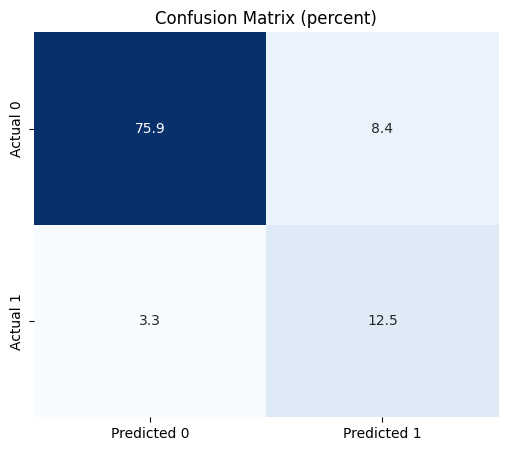

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (percent)')
plt.show()

Итак, XGBoost с лучшими гиперпараметрами на тестовой выборке ошибочно предсказала 8.4% ложноположительных результата и 3.3% ложноотрицательных. Учитыввая дисбаланс классов, модель хорошо научилась определять классы.

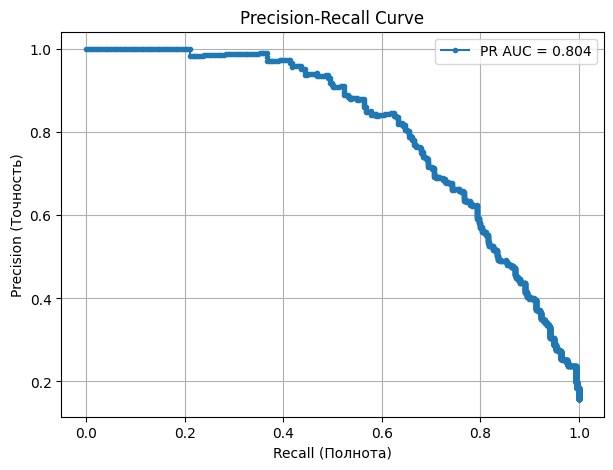

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

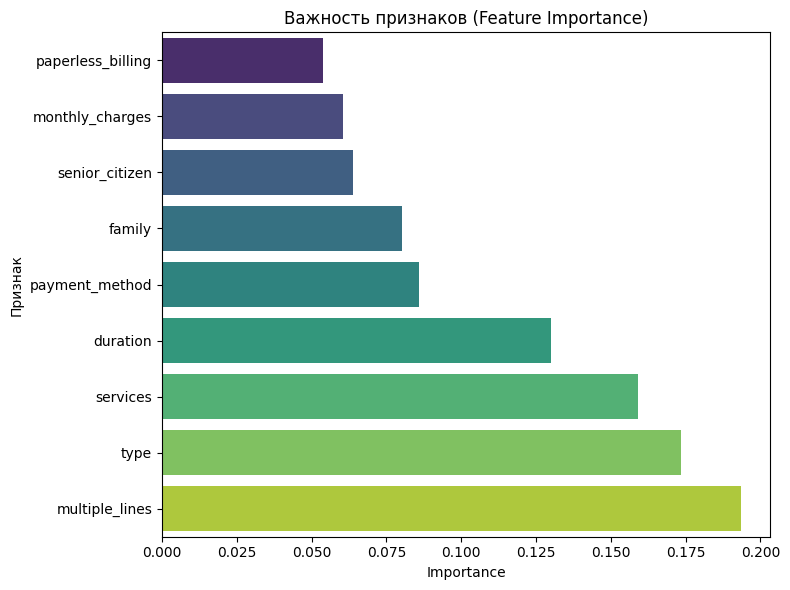

In [ ]:
booster = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessor']

num_features = preprocessor.transformers_[0][2]

cat_features = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)

bin_features = bin_cols

feature_names_processed = list(num_features) + list(cat_features) + list(bin_features)

importances = best_model.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names_processed)
feat_imp_sorted = feat_imp.sort_values(ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp_sorted.values, y=feat_imp_sorted.index,hue=feat_imp_sorted.index, palette='viridis')
plt.title('Важность признаков (Feature Importance)')
plt.xlabel('Importance')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Наиболее влиятельные признаки: `multiple_lines`, `services`, `type` — они чаще всего использовались в сплитах деревьев и давали наибольший прирост качества модели.

Менее важные признаки: `paperless_billing`, `monthly_charges` — модель использует их реже или они меньше влияют на разбиения.

 92%|==================  | 1606/1748 [00:11<00:00]       

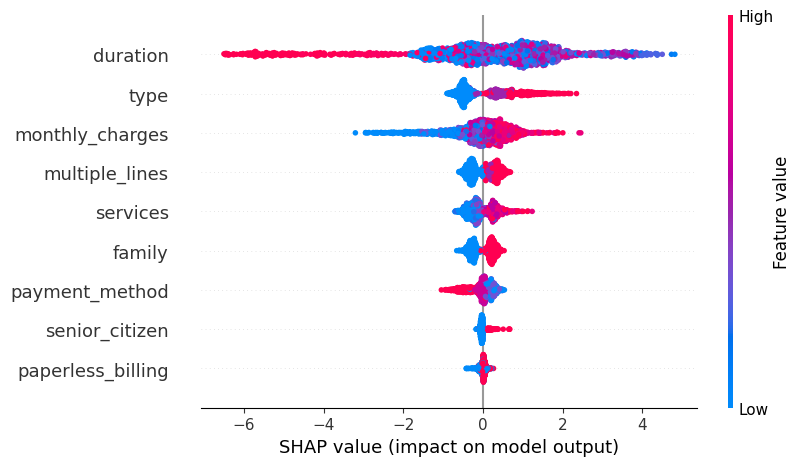

In [ ]:
X_test_processed = preprocessor.transform(X_test).astype('float32')

explainer = shap.Explainer(best_model.named_steps['model'], X_test_processed, feature_names=feature_names_processed)
shap_values = explainer(X_test_processed)
shap.plots.beeswarm(shap_values)

Топовые признаки: `duration`, `monthly_charges`, `type`, `family`.
Менее важные: `papaerless_billing`, `payment_method`, `senior_citizen`.     

SHAP и feature_importances совпадают по большинству ключевых признаков (type_Two year, services, multiple_lines), но немного меняется порядок:
- duration и monthly_charges выше в SHAP, потому что эти признаки реально сильнее влияют на прогноз конкретного клиента, даже если деревья их использовали не так часто.
- multiple_lines и services чуть ниже, возможно из-за корреляции с другими признаками.

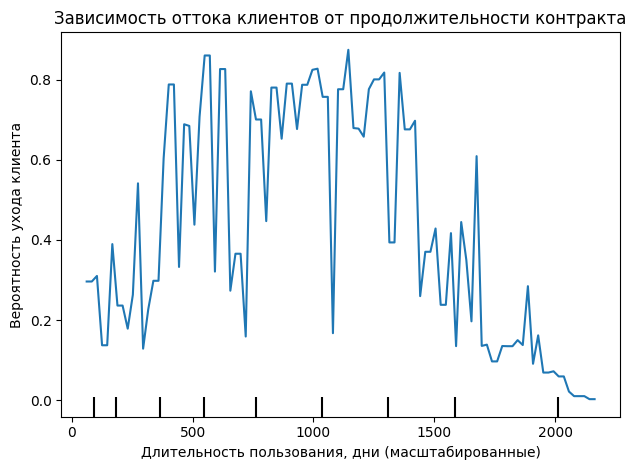

In [ ]:
feature = feature_names_processed.index('duration')

disp = PartialDependenceDisplay.from_estimator(
    best_model.named_steps['model'],
    X_test_processed,
    features=[feature],
    feature_names=feature_names_processed,
    kind='average'
)

disp.axes_[0, 0].set_title('Зависимость оттока клиентов от продолжительности контракта')
disp.axes_[0, 0].set_xlabel('Длительность пользования, дни (масштабированные)')
disp.axes_[0, 0].set_ylabel('Вероятность ухода клиента')

plt.tight_layout()
plt.show()

По графику видно, что маленькие и высокие значения длительности использования услуг компании, модель расценивала, как признак того, что клиент скорее всего не расторгнет контракт.

# Общий вывод

## Цель проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов, предлагая промокоды и специальные условия.  
**Цель проекта:** обучить модель для прогноза оттока клиентов.

---

## 1. Загрузка и анализ данных
- Выгрузили таблицы `contract`, `personal`, `internet`, `phone`.
- Проверили соответствие столбцов, отбросили нерелевантные данные.

---

## 2. Предобработка данных
- Привели названия к `snake_case`, даты к `datetime`, числовые признаки к `float`.
- Заполнили пропуски, создали новые признаки: `duration`, `target`, `services`, `family`.
- Удалили избыточные признаки.
- Провели EDA и составили портреты клиентов:
  - **Не ушедшие:** один телефон, минимальные услуги, ежемесячная оплата.
  - **Ушедшие:** несколько линий, дополнительные услуги, оплата 1–2 раза в год.
- **Вывод:** клиенты уходят из-за высокой стоимости и множества подписок.

---

## 3. Обучение моделей
- Модели: `RandomForest`, `XGBoost`, `LightGBM`, нейросеть (2 слоя, ReLU, Dropout, BCELoss).
- Категориальные признаки закодированы `OneHotEncoder`, числовые — `MinMaxScaler`.
- Подбор гиперпараметров через `GridSearchCV`.
- **Лучшая модель:** XGBoost, ROC-AUC = 0.9027 (learning_rate=0.1, max_depth=5, n_estimators=500).

---

## 4. Тестирование модели
- ROC-AUC: 0.9259, Accuracy: 0.8839
- Ложноположительные: 8.4%, ложноотрицательные: 3.3%
- **Важные признаки:** `multiple_lines`, `services`, `type_Two year`, `duration`, `monthly_charges`.
- SHAP подтвердил ключевые признаки, немного изменяется порядок влияния.
- Признак `duration` показал сильное влияние: короткий и длинный стаж — меньше риск оттока, средний — выше.

---

## Общие выводы и рекомендации
1. **Модель:** XGBoost точно прогнозирует отток клиентов.
2. **Ключевые признаки:** количество телефонных линий, дополнительные услуги, тип контракта, длительность пользования, ежемесячные платежи.
3. **Рекомендации:**
   - Нацеливать промоакции на клиентов с несколькими линиями и множеством услуг.
   - Особое внимание — на клиентов с контрактом на 1–2 года, средний стаж и высокий месячный платёж.
   - Использовать модель для прогнозов будущих клиентов и удержания.

---

**Итог:** построенная модель позволяет прогнозировать отток, выявлять ключевые факторы риска и поддерживать принятие управленческих решений.